### Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import optimizers

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


### Load the Data:

In [4]:
has_planets = pd.read_csv('../clean_planet_data/clean_labeled_planets.csv')

c4_kep = pd.read_csv('../clean_planet_data/clean_kep_c4.csv')

all_confirmed = pd.read_csv('../clean_planet_data/all_planets_list.csv')

### Making sure there are transits in the confirmed planets set:

In [3]:
# remove last line from c4_kep because it has too many nulls:
c4_kep.drop(index=7713, inplace = True)

In [6]:
# Assign what used to be exposure to 0 because we're about to change that variable
c4_kep['1'] = 0

In [7]:
# Assign labels to c4_kep
not_found = 0
stars_to_drop = []

for j in range(len(c4_kep)): # for every light curve from has_planets
    if j % 250 == 0:
        print(j)

    count = 0
    for i in range(len(all_confirmed)): # look through each star name in the list of all confirmed planets
        try:
            if all_confirmed.loc[i, 'Alternative star names'].find(c4_kep.iloc[j, 0]) != -1:
                count += 1
                print(c4_kep.iloc[j, 0], ' found @ index: ', j, 'orbital period: ', all_confirmed.loc[i, 'Orbital period [days]'])
                c4_kep.loc[j, '1'] = 1
    
        except AttributeError: # if the alternate star names value are null
            try:
                if all_confirmed.loc[i, 'Star name'].find(c4_kep.iloc[j, 0]) != -1:
                    count += 1
                    print(c4_kep.iloc[j, 0], ' found @ index: ', j, 'on 2nd level of loop', 'orbital period: ', all_confirmed.loc[i, 'Orbital period [days]'])
                    c4_kep.loc[j, '1'] = 1
                    
            except AttributeError: # if this is null too, keep going
                continue
    if count == 0:
        not_found += 1


0
KIC 10000941  found @ index:  174 orbital period:  3.5047±0.0000
250
KIC 10002866  found @ index:  265 orbital period:  3.9370±0.0000
KIC 10002866  found @ index:  265 orbital period:  28.0819±0.0001
KIC 10002866  found @ index:  265 orbital period:  10.0888±0.0000
KIC 10004519  found @ index:  328 orbital period:  9.8032±0.0000
KIC 10004738  found @ index:  338 orbital period:  56.4754±0.0002
KIC 10004738  found @ index:  338 orbital period:  92.8761±0.0008
KIC 10004738  found @ index:  338 orbital period:  13.9307±0.0001
KIC 10005788  found @ index:  398 orbital period:  10.9947±0.0000
KIC 10006581  found @ index:  430 orbital period:  40.1100±0.0002
500
KIC 10010440  found @ index:  502 orbital period:  53.5991±0.0004
KIC 10018233  found @ index:  691 orbital period:  16.2960±0.0001
KIC 10019065  found @ index:  744 orbital period:  52.6298±0.0003
750
KIC 10019643  found @ index:  771 orbital period:  21.3473±0.0001
KIC 10019643  found @ index:  771 orbital period:  7.8109±0.0001


In [8]:
c4_kep['1'].value_counts() # I counted only 6 stars with no planets with an orbit under 66 days in this set 
# indexes: 913, 986, 1028, 1099, 1553, 7167

0    7642
1      71
Name: 1, dtype: int64

In [11]:
c4_kep.drop(index = [913, 986, 1028, 1099, 1553, 7167], inplace=True)

In [12]:
c4_kep.reset_index(drop=True, inplace=True)

In [13]:
c4_kep.shape

(7707, 4158)

### Preparing Data:
Mix confirmed planets into data so the model can learn what they are like.

In [14]:
# cut out the extra data to compare across the same timeline (~3200 points)
join_planets = has_planets.iloc[:,:3199]

# split c4_kep to add to training data
to_train_on = c4_kep.head(2705).iloc[:,:3199]

# set aside the last 5000 stars as a holdout set
c4_holdout = c4_kep.tail(5000).iloc[:,:3199]

In [28]:
join_planets = join_planets.head(1129) # there are null rows at the bottom of this df

In [30]:
master_df = pd.concat([join_planets, to_train_on], axis = 0)

In [36]:
# Calculate Baseline Accuracy
val_count = master_df['1'].value_counts()
base_acc = val_count[1] / val_count.sum()

print('Baseline Acc: ', base_acc)
print(val_count)

Baseline Acc:  0.30073030777256127
0.0    2681
1.0    1153
Name: 1, dtype: int64


### Scaling
Normalize the light curves so that stars of different brightnesses can be compared.

In [37]:
# Make X and y
X = master_df.iloc[:, 2:]
y = master_df['1']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [38]:
# instantiate StandardScaler as ss
ss = StandardScaler()

In [39]:
# transpose to scale each lightcurve row (rather than columns)
X_train = X_train.T
X_test = X_test.T

# Scaling
scaled_df = ss.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df, columns=X_train.columns)

test_scaled_df = ss.fit_transform(X_test)
X_test = pd.DataFrame(test_scaled_df, columns=X_test.columns)

# Transpose back to normal
X_train = X_train.T
X_test = X_test.T

In [40]:
# make into an array and then change the dimensions
X_array = np.array(X_train)
X_array = np.expand_dims(X_array, axis = 2)

# do this for the test set too
X_test_array = np.array(X_test)
X_test_array = np.expand_dims(X_test_array, axis = 2)

### Prepare Holdout Data:

In [41]:
# slice out the light curve
unseen_data = c4_holdout.iloc[:,2:3199]

# Scale
unseen_data = unseen_data.T # transpose to scale each lightcurve row (rather than columns)

scaled_unseen = ss.fit_transform(unseen_data)
unseen_data = pd.DataFrame(scaled_unseen, columns=unseen_data.columns)

unseen_data = unseen_data.T # Transpose back to normal

# Change the dimensions so it can be put through the neural network
array_unseen = np.array(unseen_data)
array_unseen = np.expand_dims(array_unseen, axis = 2)

### Modeling:

In [374]:
# Define model architecture
model = Sequential()

# Convolutional and layer.
model.add(Conv1D(filters = 15, # tuned for 5, 15 second round
                 kernel_size = (20),  # filter size, tuned for 15, 20 second round
                 activation = 'relu',
                 input_shape = (3197, 1))) # dimensions of training data
# Pooling:
model.add(MaxPooling1D(pool_size = (5))) # tuned for 5
model.add(Dropout(0.1)) # regularization tuned for .1


# Convolutional layer
model.add(Conv1D(filters = 7, # tuned for 7
                 kernel_size = 20, # tuned for 7, 20 second round
                 activation = 'relu'))
# Pooling layer.
model.add(MaxPooling1D(pool_size = (5))) #tuned for 7, 5 second round
model.add(Dropout(0.25)) # regularization tuned for .25

# Convolutional layer
model.add(Conv1D(filters = 10, # tuned to 10
                 kernel_size = 30, # tuned to 10, second round ~30
                 activation = 'relu'))
# Pooling layer.
model.add(MaxPooling1D(pool_size = (7))) # tuned to 5
model.add(Dropout(0.5)) # regularization tuned to .5

# In order to go from a convolutional/pooling layer, we have to organize our neurons.
model.add(Flatten())

# # Fully connected layers.
# model.add(Dense(2500, activation = 'relu'))
# model.add(Dropout(0.7)) # regularization tuned to .7

# model.add(Dense(1000, activation = 'relu'))
# model.add(Dropout(0.7)) # regularization tuned to .7

model.add(Dense(600, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(600, activation = 'relu'))
model.add(Dropout(0.3))

# model.add(Dense(100, activation = 'relu'))


# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Setting learning rate and decay
learn_rate = 0.001
# coef_reduce = .75 # x% reduction in learing_rate by epoch: coef_by_epoch
# coef_by_epoch = 120

# Calculate decay
decay = 0 #(learn_rate - (coef_reduce * learn_rate)) / coef_by_epoch

# Changing adam optimization parameters
optimizers.adam(lr = learn_rate, decay = decay)

# Compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
result = model.fit(X_array,
                    y_train,
                    batch_size = 64,
                    epochs = 100,
                    verbose = 1,
                   validation_data = (X_test_array, y_test))

Train on 2875 samples, validate on 959 samples
Epoch 1/100
2875/2875 [==============================] - 22s 8ms/step - loss: 0.6264 - acc: 0.6939 - val_loss: 0.6073 - val_acc: 0.6997
Epoch 2/100
2875/2875 [==============================] - 15s 5ms/step - loss: 0.6031 - acc: 0.6991 - val_loss: 0.6381 - val_acc: 0.6997
Epoch 3/100
2875/2875 [==============================] - 14s 5ms/step - loss: 0.6001 - acc: 0.6991 - val_loss: 0.6085 - val_acc: 0.6997
Epoch 4/100
2875/2875 [==============================] - 13s 4ms/step - loss: 0.6001 - acc: 0.6991 - val_loss: 0.5981 - val_acc: 0.6997
Epoch 5/100
2875/2875 [==============================] - 12s 4ms/step - loss: 0.6004 - acc: 0.6991 - val_loss: 0.6312 - val_acc: 0.6997
Epoch 6/100
2875/2875 [==============================] - 14s 5ms/step - loss: 0.5951 - acc: 0.6991 - val_loss: 0.6119 - val_acc: 0.7028
Epoch 7/100
2875/2875 [==============================] - 11s 4ms/step - loss: 0.5871 - acc: 0.6988 - val_loss: 0.5942 - val_acc: 0.7164
E

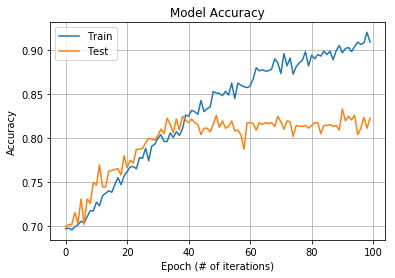

In [370]:
# Plot accuracy over time.
plt.figure()

plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch (# of iterations)')

plt.legend(['Train', 'Test'], loc='best')

plt.grid()

plt.show();

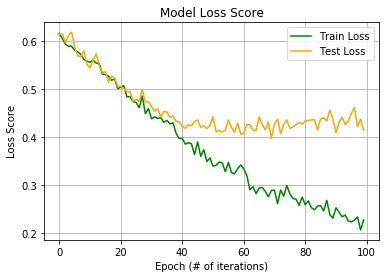

In [371]:
# Plot loss over time.
plt.figure()


plt.plot(result.history['loss'], color = 'green')
plt.plot(result.history['val_loss'], color = 'orange')


plt.title('Model Loss Score')


plt.ylabel('Loss Score')
plt.xlabel('Epoch (# of iterations)')


plt.legend(['Train Loss', 'Test Loss'], loc='best')


plt.grid()


plt.show();

### Testing on Unseen Data:
Now that the model has been fit, lets see if we can use it to detect some planets in data not seen before.

In [372]:
# Make Predictions
y_unseen = model.predict_classes(array_unseen)

In [373]:
# make predictions df
yhat_unseen = pd.DataFrame(y_unseen, columns=['prediction'])

# make df of true labels and index
true_y_unseen = c4_holdout['1']
true_y_unseen_df = pd.DataFrame(true_y_unseen)#, columns=['true'])
true_y_unseen_df.reset_index(inplace=True)

compare_df = pd.concat((true_y_unseen_df, yhat_unseen), axis=1)#, join = 'outer')

# print out prediction rate and value_counts
val_counts = yhat_unseen['prediction'].value_counts()
print(round(val_counts[1]/val_counts.sum(), 3), '% Predicted to have planets')
print(val_counts)

# print out true rate and value_counts
val_counts2 = true_y_unseen.value_counts()
print(round(val_counts2[1]/val_counts2.sum(), 3), '% actually have planets')
print(val_counts2)

true_masked = compare_df[compare_df['1'] == 1]
fp = val_counts[1] - true_masked['prediction'].sum()
tp = true_masked['prediction'].sum()

# compare predictions to true

print(tp, ' True positive planet stars predicted ',
      round((tp/val_counts[1])*100, 2), '% of all predictions',
     round((tp/val_counts[1])/(val_counts2[1]/val_counts2.sum()), 2), ' times better than chance')
print(fp, ' False postives', round((fp / val_counts[1])*100, 2), '% of all predicted')


0.071 % Predicted to have planets
0    4646
1     354
Name: prediction, dtype: int64
0.008 % actually have planets
0    4959
1      41
Name: 1, dtype: int64
7  True positive planet stars predicted  1.98 % of all predictions 2.41  times better than chance
347  False postives 98.02 % of all predicted
